In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import delfi.distribution as dd
import numpy as np
import pickle
import time
import scipy.stats as st
import os 
from lfimodels.balancednetwork.BalancedNetworkSimulator import BalancedNetwork
from lfimodels.balancednetwork.BalancedNetworkStats import BalancedNetworkStats

mpl_params = {'legend.fontsize': 14,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12}

mpl.rcParams.update(mpl_params)

In [4]:
path_to_save_folder = 'figures/'
save_figure = True

inference_method = 'snpe'
fileformat = '.png'
dpi = 400
filenames = ['1512085385027836_snpe_ree_r5_ntrain500']
#titles = ['lfi-models sept 20, delfi nov 1, svi=True', 'lfi-models sept 20, delfi nov 1, svi=False', 
#         'all nov 1, svi=False, 8 sum stats', 'all nov 1, svi=False, 19 sum stats']

param_name = r'$r_{ee}$'

dict_keys(['true_params', 'stats_obs', 'nrouns', 'ntrain', 'posterior', 'out', 'trn_data', 'prior', 'posterior_list'])
(1, 19)


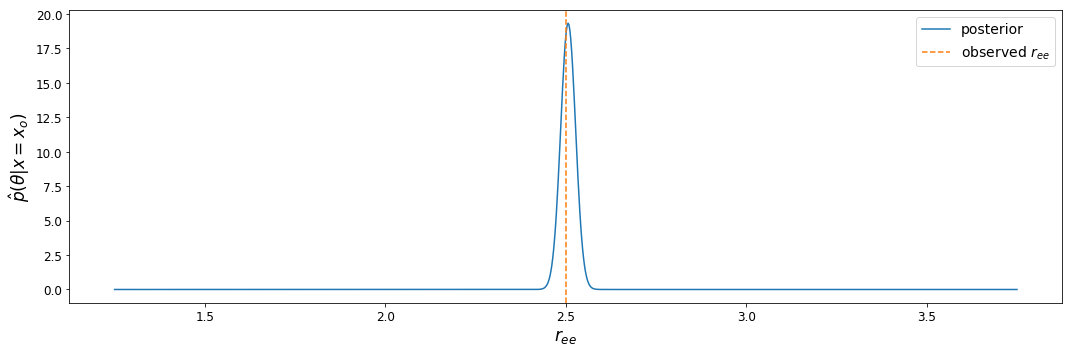

In [5]:
plt.figure(figsize=(15, 5))

for idx, filename in enumerate(filenames): 
    time_str = filename[:filename.find('_')]
    fullname = 'data/' + filename + '.p'

    # load data 
    with open(fullname, 'rb') as handle:
        result_dict = pickle.load(handle)

    print(result_dict.keys())
    # unpack values 
    try: 
        true_params, stats_obs, nrounds, ntrain, posterior, out, trn_data, prior, posteriors = result_dict.values()
        theta = np.linspace(prior.lower[0], prior.upper[0], 1000)
    except ValueError:
        try: 
            true_params, stats_obs, nrounds, ntrain, posterior, out, trn_data, prior = result_dict.values()            
            theta = np.linspace(prior.lower[0], prior.upper[0], 1000)
        except ValueError: 
            true_params, stats_obs, nrounds, ntrain, posterior, out, trn_data= result_dict.values()            
            theta = np.linspace(0, 5, 1000)
#    assert len(true_params) == 1, 'this notebook is for inference on 1 parameter: len(params)'

    nrounds = len(out)
    
    print(stats_obs.shape)

    # extract the posterior 
    n_components = len(posterior.a)
    means = [posterior.xs[c].m for c in range(n_components)]
    Ss = [posterior.xs[c].S for c in range(n_components)]

    sub_means = [[means[c][0]] for c in range(n_components)]
    sub_cov = np.asarray([Ss[c] for c in range(n_components)])
    pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)
    post_pdf = pdf.eval(theta[:, np.newaxis], log=False)

    plt.subplot(len(filenames), 1, idx + 1)
    plt.plot(theta, post_pdf, label='posterior')
    plt.axvline(x=true_params[0], label=r'observed {}'.format(param_name), linestyle='--', color='C1')
    plt.legend()
    plt.xlabel(param_name)
    if idx == 0: 
        plt.ylabel(r'$\hat{p}( \theta | x=x_{o})$')
    
if len(filenames) > 1: 
    filename = time_str + '_combined_results'
else: 
    filename = time_str + '_{}_posterior_r{}_ntrain{}'.format(inference_method, nrounds, ntrain)
    
plt.tight_layout()

if save_figure and os.path.exists(path_to_save_folder): 
    plt.savefig(os.path.join(path_to_save_folder, filename + fileformat), dpi=dpi);

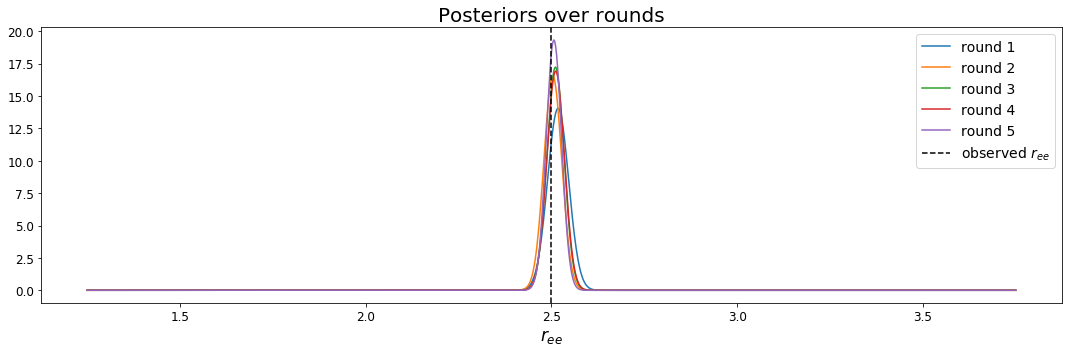

In [6]:
plt.figure(figsize=(15, 5))

for idx, posterior in enumerate(posteriors): 
    n_components = len(posterior.a)
    means = [posterior.xs[c].m for c in range(n_components)]
    Ss = [posterior.xs[c].S for c in range(n_components)]

    sub_means = [[means[c][0]] for c in range(n_components)]
    sub_cov = np.asarray([Ss[c] for c in range(n_components)])
    pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)
    post_pdf = pdf.eval(theta[:, np.newaxis], log=False)

    plt.plot(theta, post_pdf, label='round {}'.format(idx + 1))
    plt.xlabel(param_name)
    
plt.axvline(x=true_params[0], label=r'observed {}'.format(param_name), linestyle='--', color='k')
plt.legend()
plt.title('Posteriors over rounds');

plt.tight_layout()
filename = time_str + '_{}_posteriors_over_rounds_r{}_ntrain{}'.format(inference_method, nrounds, ntrain)
if save_figure and os.path.exists(path_to_save_folder): 
    plt.savefig(os.path.join(path_to_save_folder, filename + fileformat), dpi=dpi);

## Plotting the summary stats 

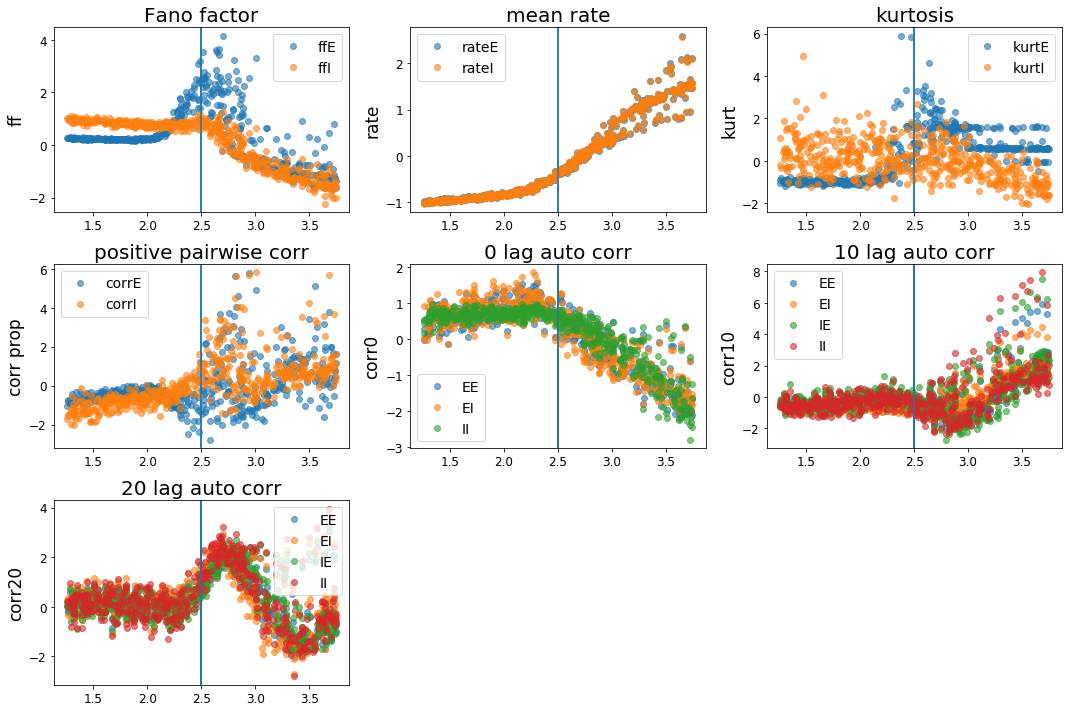

In [7]:
plt.figure(figsize=(15, 10))
p = trn_data[0][0].flatten()
ss = trn_data[0][1]
titles = ['Fano factor', 'mean rate', 'kurtosis', 'positive pairwise corr', 
          '0 lag auto corr', '10 lag auto corr', '20 lag auto corr']
ylabels = ['ff', 'rate', 'kurt', 'corr prop',
                                    'corr0',
                                    'corr10',
                                    'corr20']

labels = ['ffE', 'ffI', 'rateE', 'rateI', 'kurtE', 'kurtI', 'corrE', 'corrI',
                                    'EE', 'EI', 'II',
                                    'EE', 'EI', 'IE', 'II',
                                    'EE', 'EI', 'IE', 'II']
plot_idx = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]

for idx, s in enumerate(ss.T): 
    plt.subplot(3, 3, plot_idx[idx])
    plt.plot(p, s, 'o', label=labels[idx], alpha=.6)
    plt.title(titles[plot_idx[idx] - 1])
    plt.ylabel(ylabels[plot_idx[idx] - 1])
    plt.legend()
    plt.axvline(x=true_params[0])
plt.tight_layout()

filename = time_str + '_{}_summary_stats_r{}_ntrain{}'.format(inference_method, nrounds, ntrain)
if save_figure and os.path.exists(path_to_save_folder): 
    plt.savefig(os.path.join(path_to_save_folder, filename + fileformat), dpi=dpi);

In [8]:
posterior.mean

array([ 2.50656896])

## Posterior predictive checking 

Generate samples from the posterior and simulate them. The resulting data should be near the observed data. 

In [ ]:
m = BalancedNetwork(inference_param='ree', n_servers=1, duration=3., first_port=8010, 
                    save_raster_plots=True, 
                    save_folder='/Users/Jan/Dropbox/Master/mackelab/code/lfi-experiments/balancednetwork/figures/simulation_raster_plots/')
s = BalancedNetworkStats(n_workers=2)

In [ ]:
# calculate mean of mixture 
mean = np.sum([a * m[0] for a, m in zip(posterior.a, means)])
# calculate variance of mixture 
sum_squared = np.sum([a * m[0]**2 for a, m in zip(posterior.a, means)])
squared_sum = mean**2
std = np.sum([a * Ss[0][0] for a, m in zip(posterior.a, Ss)]) + sum_squared - squared_sum

In [ ]:
m.start_server()
# generate theta +-3, 2, 1 0 stds away from mode
thetas = [mean + i * std for i in [-1, 0, 1]]
sum_stats = []
# simulate and collect sum stats
data = m.gen(thetas)

In [ ]:
sum_stats = s.calc_all(data)

In [ ]:
sum_stats

In [ ]:
# plot the resulting stats with the observed stats 
plt.figure(figsize=(8, 4))
sum_stats = np.array(sum_stats).squeeze()
plt.axvline(x=mean, linestyle='--', color='C4')
plt.axvline(x=true_params, linestyle='--', color='C5')

plt.plot(thetas, sum_stats, '-o')
plt.plot(thetas[1], stats_obs, '*')

#plt.legend(['posterior mean', 'true theta', 'ff1', 'rate mean', 'kurtosis', 'rel corr'])
plt.xlabel('theta')
plt.ylabel('stats')
plt.title('Summary stats +-3 std around the posterior mean')

filename = '{}_ppch_r{}_ntrain{}'.format(inference_method, nrounds, ntrain)
plt.tight_layout()
if save_figure and os.path.exists(path_to_save_folder): 
    plt.savefig('figures/' + filename + fileformat, dpi=dpi);

In [ ]:
theta

In [ ]:
sum_stats[0].shape

## Compare only simulation of mean posterior vs. original parameters

In [ ]:
jee = posterior.mean[0]

In [ ]:
plt.figure(figsize=(15, 5))
labels = ['ffE', 'ffI', 'rateE', 'rateI', 'kurtE', 'kurtI', 'corrE', 'corrI',
                                    '0EE', '0EI', '0II',
                                    '10EE', '10EI', '10IE', '10II',
                                    '20EE', '20EI', '20IE', '20II']
plt.plot(sum_stats[0].flatten(), '-o', label='- 1 SD posterior')
plt.plot(sum_stats[1].flatten(), '-o', label='mean posterior')
plt.plot(sum_stats[2].flatten(), '-o', label='+ 1 SD posterior')
ax = plt.plot(stats_obs.T, '--*', label='observed')
plt.xticks(np.arange(19), labels)
plt.gca().tick_params(axis='x')
plt.legend()

filename = '{}_ppch_ntrain{}_{}'.format(inference_method, ntrain, param_name)

plt.tight_layout()
if save_figure and os.path.exists(path_to_save_folder): 
    plt.savefig('figures/' + filename + fileformat, dpi=dpi);

In [ ]:
plt.savefig?